# Predicting TESLA stock price 

## First we need to download financial data

Before running the code: 

pip install yahoofinancials, pip install yfinance, pip install tensorflow

In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 



Steps to build stock prediction model 
    - Data processing
    - Building the RNN 
    - Making prediction and visualizatiuon 

### Data Visualization

In [7]:
#import external pandas_datareader library with alias of web
import pandas_datareader as web
import datetime

# define the time frame of the data

start = datetime.datetime(2005, 9, 1)
end = datetime.datetime(2019, 12, 31)
 
#DataReader method name is case sensitive
df = web.DataReader("^GDAXI",'yahoo', start, end)
 
df.to_csv('DAX30.csv')

data = pd.read_csv('DAX30.csv',date_parser = True)
data.tail()

### Splitting into training and test data

In [8]:
data = pd.read_csv('DAX30.csv',date_parser = True)
data.tail()


,Date,High,Low,Open,Close,Volume,Adj Close
3627,2019-12-19,13248.980469,13140.219727,13226.700195,13211.959961,84018200.0,13211.959961
3628,2019-12-20,13324.110352,13201.799805,13210.259766,13318.900391,170723200.0,13318.900391
3629,2019-12-23,13331.860352,13285.549805,13304.769531,13300.980469,56215400.0,13300.980469
3630,2019-12-27,13381.440430,13311.519531,13338.320312,13337.110352,43758600.0,13337.110352
3631,2019-12-30,13316.620117,13244.169922,13301.429688,13249.009766,31427400.0,13249.009766


In [9]:
data_training = data[data['Date']<'2018-01-01'].copy()
data_training

,Date,High,Low,Open,Close,Volume,Adj Close
0,2005-09-01,4874.890137,4816.669922,4846.660156,4842.939941,102111400.0,4842.939941
1,2005-09-02,4861.930176,4819.100098,4841.379883,4837.810059,92755300.0,4837.810059
2,2005-09-05,4909.890137,4850.529785,4853.600098,4909.890137,58985900.0,4909.890137
3,2005-09-06,4969.419922,4901.899902,4903.390137,4968.279785,93517800.0,4968.279785
4,2005-09-07,5004.229980,4967.680176,4977.919922,4988.140137,102181700.0,4988.140137
...,...,...,...,...,...,...,...
3125,2017-12-21,13137.709961,13013.629883,13065.790039,13109.740234,70360200.0,13109.740234
3126,2017-12-22,13108.559570,13059.870117,13076.759766,13072.790039,52876700.0,13072.790039
3127,2017-12-27,13128.740234,13020.429688,13070.190430,13070.019531,44677000.0,13070.019531
3128,2017-12-28,13069.400391,12965.280273,13065.459961,12979.940430,43152100.0,12979.940430


In [10]:
data_test = data[data['Date']>'2018-01-01'].copy()
data_test

,Date,High,Low,Open,Close,Volume,Adj Close
3130,2018-01-02,12924.160156,12745.150391,12897.690430,12871.389648,86049300.0,12871.389648
3131,2018-01-03,13023.589844,12893.049805,12916.179688,12978.209961,84809300.0,12978.209961
3132,2018-01-04,13208.349609,13062.669922,13065.980469,13167.889648,101199400.0,13167.889648
3133,2018-01-05,13332.799805,13219.110352,13219.110352,13319.639648,112555000.0,13319.639648
3134,2018-01-08,13407.820312,13334.160156,13399.620117,13367.780273,95005300.0,13367.780273
...,...,...,...,...,...,...,...
3627,2019-12-19,13248.980469,13140.219727,13226.700195,13211.959961,84018200.0,13211.959961
3628,2019-12-20,13324.110352,13201.799805,13210.259766,13318.900391,170723200.0,13318.900391
3629,2019-12-23,13331.860352,13285.549805,13304.769531,13300.980469,56215400.0,13300.980469
3630,2019-12-27,13381.440430,13311.519531,13338.320312,13337.110352,43758600.0,13337.110352


In [11]:
# Date and Adj Close are not interesting so I will drop it

training_data = data_training.drop(['Date','Adj Close'], axis = 1)

In [12]:
training_data.head()

,High,Low,Open,Close,Volume
0,4874.890137,4816.669922,4846.660156,4842.939941,102111400.0
1,4861.930176,4819.100098,4841.379883,4837.810059,92755300.0
2,4909.890137,4850.529785,4853.600098,4909.890137,58985900.0
3,4969.419922,4901.899902,4903.390137,4968.279785,93517800.0
4,5004.229980,4967.680176,4977.919922,4988.140137,102181700.0


In [13]:
scaler = MinMaxScaler() #scaling data between 0 and 1 
training_data = scaler.fit_transform(training_data)
training_data

array([[0.11900821, 0.12461267, 0.11884979, 0.11990176, 0.18260868],
       [0.11768835, 0.12485932, 0.11831322, 0.11937896, 0.16309458],
       [0.12257264, 0.12804926, 0.119555  , 0.12672474, 0.09266141],
       ...,
       [0.95958757, 0.95724751, 0.95449709, 0.95833448, 0.0628172 ],
       [0.95354435, 0.95165016, 0.9540164 , 0.9491544 , 0.0596367 ],
       [0.94451512, 0.94621516, 0.94534138, 0.94280524, 0.05758665]])

In [14]:
X_train = []
y_train = []


In [15]:
for i in range(60, training_data.shape[0]):# windows of 60 days 
    X_train.append(training_data[i-60:i])
    y_train.append(training_data[i,0])

In [16]:
X_train= np.array(X_train)

In [17]:
X_train.shape

(3070, 60, 5)

## Building the LSTM

In [18]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout 

In [50]:
regressor = Sequential()

regressor.add(LSTM(units = 100, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],5)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 300, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 400, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 500, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 300, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))


regressor.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 100, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 50, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

In [51]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 60, 100)           42400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 60, 120)           106080    
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 120)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 60, 200)           256800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 200)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 60, 300)          

In [52]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [54]:
regressor.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
96/96 [==============================] - 107s 1s/step - loss: 0.0160
Epoch 2/10
96/96 [==============================] - 107s 1s/step - loss: 0.0121
Epoch 3/10
96/96 [==============================] - 108s 1s/step - loss: 0.0106
Epoch 4/10
96/96 [==============================] - 110s 1s/step - loss: 0.0107
Epoch 5/10
96/96 [==============================] - 109s 1s/step - loss: 0.0094
Epoch 6/10
96/96 [==============================] - 108s 1s/step - loss: 0.0082
Epoch 7/10
96/96 [==============================] - 108s 1s/step - loss: 0.0083
Epoch 8/10
96/96 [==============================] - 107s 1s/step - loss: 0.0072
Epoch 9/10
96/96 [==============================] - 108s 1s/step - loss: 0.0074
Epoch 10/10
96/96 [==============================] - 109s 1s/step - loss: 0.0065


Now we need to test and compare 

### Preparing test data

In [55]:
past_60_days = data_training.tail(60)

In [56]:
df = past_60_days.append(data_test, ignore_index = True)
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-10-04,12976.240234,12893.750000,12955.889648,12970.519531,115228700.0,12970.519531
1,2017-10-05,12969.400391,12933.559570,12950.179688,12968.049805,78532500.0,12968.049805
2,2017-10-06,12993.530273,12941.150391,12979.339844,12955.940430,73029000.0,12955.940430
3,2017-10-09,12996.639648,12943.549805,12975.860352,12976.400391,60873300.0,12976.400391
4,2017-10-10,12980.450195,12909.280273,12959.719727,12949.250000,65253500.0,12949.250000
...,...,...,...,...,...,...,...
557,2019-12-19,13248.980469,13140.219727,13226.700195,13211.959961,84018200.0,13211.959961
558,2019-12-20,13324.110352,13201.799805,13210.259766,13318.900391,170723200.0,13318.900391
559,2019-12-23,13331.860352,13285.549805,13304.769531,13300.980469,56215400.0,13300.980469
560,2019-12-27,13381.440430,13311.519531,13338.320312,13337.110352,43758600.0,13337.110352


In [57]:
df = df.drop(['Date','Adj Close'], axis = 1)
df.head()

,High,Low,Open,Close,Volume
0,12976.240234,12893.750000,12955.889648,12970.519531,115228700.0
1,12969.400391,12933.559570,12950.179688,12968.049805,78532500.0
2,12993.530273,12941.150391,12979.339844,12955.940430,73029000.0
3,12996.639648,12943.549805,12975.860352,12976.400391,60873300.0
4,12980.450195,12909.280273,12959.719727,12949.250000,65253500.0


In [58]:
# scaling values 
inputs = scaler.transform(df)
inputs

array([[0.94405683, 0.94439024, 0.94288223, 0.9481943 , 0.20996757],
       [0.94336026, 0.94843069, 0.94230201, 0.94794261, 0.13342994],
       [0.94581767, 0.94920111, 0.94526516, 0.94670853, 0.12195124],
       ...,
       [0.9802735 , 0.98415569, 0.97833423, 0.98187202, 0.08688295],
       [0.98532278, 0.98679147, 0.98174354, 0.98555407, 0.06090168],
       [0.97872142, 0.97995587, 0.97799484, 0.97657562, 0.03518238]])

In [59]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])

In [60]:
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_test.shape

(502, 60, 5)

## Prediction 

In [61]:
y_pred = regressor.predict(X_test)

In [62]:
scaler.scale_

array([1.01840881e-04, 1.01494298e-04, 1.01616615e-04, 1.01911343e-04,
       2.08570974e-09])

In [63]:
scale = 1/2.70657980e-03
scale

369.46998569929474

In [64]:
y_pred = y_pred * scale
y_test = y_test*scale

### Vizualisation 

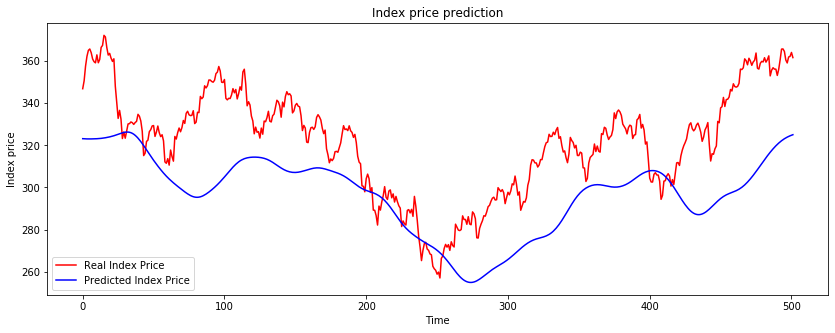

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(14,5))
plt.plot(y_test,color = 'red', label = 'Real Index Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Index Price')
plt.title('Index price prediction')
plt.xlabel('Time')
plt.ylabel('Index price')
plt.legend()
plt.show()
plt.savefig('books_read.png')